In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('ggplot')

idx = pd.IndexSlice

root = Path.cwd().parent.parent.parent / "cluster_data"

In [2]:
def get_data(mode, op):

    if mode == "chp" or mode == "dh":
        df = pd.read_csv(root / f"{mode}_data" / f"csvs_{op}" / "nodal_capacities.csv", index_col=[0,1,2], header=[0,1,2,3,4,5,6])
    elif mode == "elec":
        df = pd.read_csv(root / f"{mode}_data" / "csvs" / "nodal_capacities.csv", index_col=[0,1,2], header=[0,1,2,3,4,5,6])


    df = df.groupby(level=[0,2]).sum()
    df.columns = df.columns.droplevel([0,1,2,3,5])

    df["carrier"] = df.index.get_level_values(1)
    df.index = df.index.droplevel(1)

    df.index += " " + df.carrier

    df = df.loc[df.carrier.isin(["geothermal heat", "geothermal heat elec"])]
    df.drop("carrier", axis=1, inplace=True)
    df = df.loc[:, idx[:, op]]
    df.columns = df.columns.droplevel(1)

    return df.loc["links geothermal heat"].mul(0.5).mul(1e-3)

elec_static = get_data("elec", "static")
elec_flex = get_data("elec", "flex")

dh_static = get_data("dh", "static")
dh_flex = get_data("dh", "flex")

chp_static = get_data("chp", "static")
chp_flex = get_data("chp", "flex")

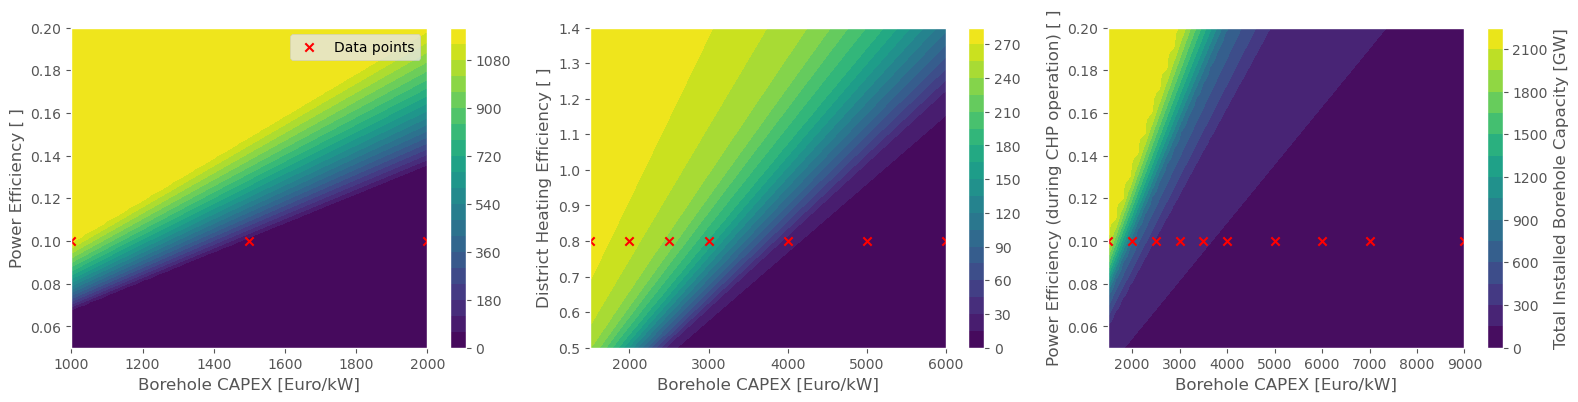

In [5]:
def get_z(
        base_value,
        min_value,
        max_values,
        steps,
        capex,
        z,
    ):

    etas = np.linspace(min_value, max_values, steps)

    capexes = np.linspace(min(capex), max(capex), steps)
    capexes, etas = np.meshgrid(capexes, etas)

    final_z = np.zeros((steps, steps))
    for i, eta in enumerate(etas):

        local_capexes = capex * eta.mean() / base_value
        final_z[i] = np.interp(capexes[i], local_capexes, z)

    return capexes, etas, final_z

fig, axs = plt.subplots(1, 3, figsize=(16, 4))

############################################################3

eta_elec = 0.1
eta_dh = 0.8
start_eta = 0.05
end_eta = 0.2
num_steps = 50

plot_x, plot_y, plot_z = get_z(
    eta_elec,
    start_eta,
    end_eta,
    num_steps,
    elec_static.index.values.astype(float),
    elec_static.values,
    )

cbar = axs[0].contourf(
    plot_x,
    plot_y,
    plot_z,
    levels=20, cmap="viridis")
cbar = fig.colorbar(cbar, ax=axs[0])#, label="Total Installed Borehole Capacity [GW]")

axs[0].scatter(
    elec_static.index.values.astype(float),
    np.ones(len(elec_static)) * eta_elec,
    label="Data points",
    color="r",
    marker='x',
    )
axs[0].legend()
axs[0].set_ylabel("Power Efficiency [ ]")
axs[0].set_xlabel("Borehole CAPEX [Euro/kW]")

############################################################3

start_eta = 0.5
end_eta = 1.4
num_steps = 50

plot_x, plot_y, plot_z = get_z(
    eta_dh,
    start_eta,
    end_eta,
    num_steps,
    dh_static.index.values.astype(float),
    dh_static.values,
    )

cbar = axs[1].contourf(
    plot_x,
    plot_y,
    plot_z,
    levels=20, cmap="viridis")
cbar = fig.colorbar(cbar, ax=axs[1])#, label="Total Installed Borehole Capacity [GW]")

axs[1].scatter(
    dh_static.index.values.astype(float),
    np.ones(len(dh_static)) * eta_dh,
    label="Data points",
    color="r",
    marker='x',
    )
# axs[0].legend()
axs[1].set_ylabel("District Heating Efficiency [ ]")
axs[1].set_xlabel("Borehole CAPEX [Euro/kW]")

############################################################3

start_eta = 0.05
end_eta = 0.2
num_steps = 50

plot_x, plot_y, plot_z = get_z(
    eta_elec,
    start_eta,
    end_eta,
    num_steps,
    chp_static.index.values.astype(float),
    chp_static.values,
    )

cbar = axs[2].contourf(
    plot_x,
    plot_y,
    plot_z,
    levels=20, cmap="viridis")
cbar = fig.colorbar(cbar, ax=axs[2], label="Total Installed Borehole Capacity [GW]")

axs[2].scatter(
    chp_static.index.values.astype(float),
    np.ones(len(chp_static)) * eta_elec,
    label="Data points",
    color="r",
    marker='x',
    )
# axs[0].legend()
axs[2].set_ylabel("Power Efficiency (during CHP operation) [ ]")
axs[2].set_xlabel("Borehole CAPEX [Euro/kW]")

plt.tight_layout()
plt.show()